In [1]:
import fit_IEM_v2 as IEM
import numpy as np
import pandas as pd
import circ_corr as cc
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
pi=np.pi

subjs = ['UCSD0' + x for x in ['54','60','61','62','63','64']]
rois = ['V1', 'V2', 'V3', 'hV4', 'V3AB','IPS0','IPS1','IPS2', 'VO', 'LO', 'TO', ]

n_subj = len(subjs)
n_roi = len(rois)
t_view = 6.4 
t_use = int((t_view/0.8)+4)
t_use_try = np.arange(4,36,2) 
roi_show = ['V1','V2','V3','IPS0']
# sav_root = '/mnt/neurocube/local/serenceslab/tsheehan/IterativeFitsCD/v3/'
pd.set_option('display.max_columns', None)

data_root = '/mnt/neurocube/local/serenceslab/tsheehan/CD_Task/Analysis/SignalProcessingSeg/'
bad_sess = ['201910011846','201907231305'] # first one repeat from 54

In [2]:
def sav_fig(nam):
    root = './Figs/'
    plt.savefig(root + nam +'.svg',dpi=1200)

import matplotlib
cmap = matplotlib.cm.get_cmap('Dark2')
ct = cmap(np.linspace(0,1,4))

plt.rcParams.update({'font.size': 14
                    })

In [3]:
def wrap(x):
    x[np.abs(x)>90]-=180*np.sign(x[np.abs(x)>90])
    return x

In [4]:

# @title Helper Functions

def plot_covariance(covar):
    plt.imshow(covar)
    plt.colorbar()
    plt.title('Covariance Matrix (\u03A3)')
    plt.show()

    
def plot_variance_explained(variance_explained):
  """
  Plots eigenvalues.

  Args:
    variance_explained (numpy array of floats) : Vector of variance explained
                                                 for each PC

  Returns:
    Nothing.

  """

  plt.figure()
  plt.plot(np.arange(1, len(variance_explained) + 1), variance_explained,
           'k')
  plt.xlabel('Number of components')
  plt.ylabel('Variance explained')
  plt.axhline(.9,c='r',ls='--')
#   plt.show()


def change_of_basis(X, W):
  """
  Projects data onto a new basis.

  Args:
    X (numpy array of floats) : Data matrix each column corresponding to a
                                different random variable
    W (numpy array of floats) : new orthonormal basis columns correspond to
                                basis vectors

  Returns:
    (numpy array of floats)   : Data matrix expressed in new basis
  """

  Y = np.matmul(X, W)

  return Y


def get_sample_cov_matrix(X):
  """
  Returns the sample covariance matrix of data X.

  Args:
    X (numpy array of floats) : Data matrix each column corresponds to a
                                different random variable

  Returns:
    (numpy array of floats)   : Covariance matrix
"""

  X = X - np.mean(X, 0)
  cov_matrix = 1 / X.shape[0] * np.matmul(X.T, X)
  return cov_matrix


def sort_evals_descending(evals, evectors):
  """
  Sorts eigenvalues and eigenvectors in decreasing order. Also aligns first two
  eigenvectors to be in first two quadrants (if 2D).

  Args:
    evals (numpy array of floats)    :   Vector of eigenvalues
    evectors (numpy array of floats) :   Corresponding matrix of eigenvectors
                                         each column corresponds to a different
                                         eigenvalue

  Returns:
    (numpy array of floats)          : Vector of eigenvalues after sorting
    (numpy array of floats)          : Matrix of eigenvectors after sorting
  """

  index = np.flip(np.argsort(evals))
  evals = evals[index]
  evectors = evectors[:, index]
  if evals.shape[0] == 2:
    if np.arccos(np.matmul(evectors[:, 0],
                           1 / np.sqrt(2) * np.array([1, 1]))) > np.pi / 2:
      evectors[:, 0] = -evectors[:, 0]
    if np.arccos(np.matmul(evectors[:, 1],
                           1 / np.sqrt(2)*np.array([-1, 1]))) > np.pi / 2:
      evectors[:, 1] = -evectors[:, 1]

  return evals, evectors


def pca(X):
  """
  Performs PCA on multivariate data. Eigenvalues are sorted in decreasing order

  Args:
     X (numpy array of floats) :   Data matrix each column corresponds to a
                                   different random variable

  Returns:
    (numpy array of floats)    : Data projected onto the new basis
    (numpy array of floats)    : Vector of eigenvalues
    (numpy array of floats)    : Corresponding matrix of eigenvectors

  """

  X = X - np.mean(X, 0)
  cov_matrix = get_sample_cov_matrix(X)
  evals, evectors = np.linalg.eigh(cov_matrix)
  evals, evectors = sort_evals_descending(evals, evectors)
  score = change_of_basis(X, evectors)

  return score, evectors, evals


def plot_eigenvalues(evals, limit=True):
  """
  Plots eigenvalues.

  Args:
     (numpy array of floats) : Vector of eigenvalues

  Returns:
    Nothing.

  """

  plt.figure()
  plt.plot(np.arange(1, len(evals) + 1), evals, 'o-k')
  plt.xlabel('Component')
  plt.ylabel('Eigenvalue')
  plt.title('Scree plot')
  if limit:
    plt.show()
    
    
def plot_eigenvectors(eigenvectors, feature_names):
    plt.figure(figsize=(10,5))
    plt.imshow(eigenvectors,cmap='viridis',)
    plt.yticks([0,1,2],['PC1','PC2','PC3'],fontsize=10)
    plt.colorbar(orientation='horizontal')
    plt.tight_layout()
    plt.xticks(range(len(feature_names)),feature_names,rotation=65)
    plt.show()


# def plot_pca_labels(score,labels):
# #     plt.figure()
#     plt.scatter(score[:, 0], score[:, 1],c=labels,cmap='jet')
#     plt.xlabel('PCA 1')
#     plt.ylabel('PCA 2')
#     plt.axis('equal')
#     plt.colorbar()
#     plt.show()
    
def plot_pca_labels_with_centroids(score,labels,centers):
    plt.figure()
    plt.scatter(score[:, 0], score[:, 1],c=labels,cmap='jet')
    plt.xlabel('PCA 1')
    plt.ylabel('PCA 2')
    plt.axis('equal')
    plt.colorbar()
    plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)
    plt.show()

In [5]:
paramsT={'donut':75,'anovaP':50}
paramsL={'donut':75,'anovaP':99}

In [6]:
def voxel_selection(samples,ev,params):
    # samples (voxels x trials)
    ind_all = np.arange(samples.shape[0])
    # donut selection
    donut_voxels = IEM.get_donut_mask(samples,ev,params['donut']) #minimun percentile
    donut_trials = (ev.d1.values==1)
    # anova selection
    samples_donut = samples[donut_voxels,:]
    samples_donut = samples_donut[:,donut_trials]
    ind_all_donut=ind_all[donut_voxels]
    
    ori = ev[donut_trials].d0.values
    ori_anova = np.round((ori-10)/2,-1)
    f_stats= IEM.anova1(samples_donut,ori_anova)
    n_keep = int(np.sum(donut_voxels)/2)
    ind_keep = np.argsort(f_stats)[-n_keep:]
    ind_all_both = ind_all_donut[ind_keep]
    print('%d -> %d voxels' %(samples.shape[0],len(ind_all_both)))
    return ind_all_both, ind_all_donut

In [7]:
import DecodeNoiseCorrelation as DNC
D = DNC.noiseModeling()

In [ ]:
DAT_ALL = []
subj = 'UCSD060'
roi = 'V3'
roi_snag = ['V1','V2','V3','V3AB','hV4','IPS0']
# roi_snag = ['V3']
for subj in subjs:
    _DAT_ALL = []
    for roi in roi_snag:
        


        file = data_root + subj +'_dat_wTimeFix.pickle'
        dat = pd.read_pickle(file)
        ev_loc = dat.EV_LOC.copy()
        donut_ev = ev_loc.d1.values==1
        trial_not_1 = ev_loc.trial.values!=1
        donut_ev_1 = np.concatenate([[False],donut_ev[:-1]])
        donut_use = donut_ev&donut_ev_1&trial_not_1

        ev_loc_train = ev_loc[donut_ev]

        ori_loc_all = D.foldPred(ev_loc.d0.values.copy())
        ori_loc_n_1 = np.concatenate([[np.nan],ori_loc_all[:-1]])
        ori_loc = ori_loc_n_1[donut_use]

        dat_loc = dat['DAT_LOC'][roi] # jump right to these timepoints
        dat_task = np.nanmean(dat['DAT_TASK'][roi][:,:,t_use:t_use+4],2) # time x voxel x trials --> voxel x trial
        #### voxel & trial clean
        # Localizer
        vox_use,_ = voxel_selection(dat_loc,ev_loc,paramsT)
        _,vox_use_donut_only = voxel_selection(dat_loc,ev_loc,paramsL)
        dat_loc_train0 = dat_loc[vox_use,:]
        dat_loc_train1 = dat_loc[vox_use_donut_only,:]
        #             dat_loc_train = dat_loc_train0[:,donut_ev].T
        dat_loc_train = dat_loc_train0[:,donut_use].T

        # Task
        ev_task_og = dat.EV_TASK.copy()
        ori_og = ev_task_og.orient0+90

        bad_ev = np.isin(ev_task_og.sess,bad_sess)
        bad_trials = np.any(np.isnan(dat_task),0)

        dat_task_train = dat_task[vox_use,:]
        dat_task_train = dat_task_train[:,~bad_ev&~bad_trials].T # get rid of NaNs

        ev_task = ev_task_og[~bad_ev&~bad_trials]
        ori_task = ori_og[~bad_ev&~bad_trials] # setup n-1 ori
        dat_task_full = dat_task[:,~bad_ev&~bad_trials].T
        _DAT_ALL.append((dat_task_train,dat_task_full,ori_task))
    DAT_ALL.append(_DAT_ALL)

In [ ]:
thresh =30
n_bin = 24
var_cuttoff=0.9
roi_analyze = 1
plt.figure(figsize=(12,18))
n_dims = []
auc = []
PR = []

for si,subj in enumerate(subjs):
    
    d_use = DAT_ALL[si][roi_analyze][0]
    ori_task = DAT_ALL[si][roi_analyze][2]
    n_block = len(ori_task)//17
    trials = np.concatenate([np.arange(17) for _ in range(n_block)])
    d_ori = np.concatenate(([0],wrap(ori_task[:-1].values - ori_task[1:].values)))
    close = (np.abs(d_ori)<=thresh)&(trials>0)
    far = (np.abs(d_ori)>=90-thresh)&(trials>0)
    print(np.sum(close),np.sum(far))
    # must downsample the smaller group!
    if np.sum(close)>np.sum(far): # more close samples...
        n_remove = np.sum(close)-np.sum(far)
        all_samp = np.nonzero(close)[0]
        reset_inds = np.random.choice(all_samp,n_remove,replace=False)
        close[reset_inds]=False
    elif np.sum(close)<np.sum(far): 
        n_remove = np.sum(far)-np.sum(close)
        all_samp = np.nonzero(far)[0]
        reset_inds = np.random.choice(all_samp,n_remove,replace=False)
        far[reset_inds]=False
    print(np.sum(close),np.sum(far))
    
    score_close, evectors_close, evals_close = pca(d_use[close])  ## this is the answer they need to fill in 
    score_far, evectors_far, evals_far = pca(d_use[far])  ## this is the answer they need to fill in 
    
    score, evectors, evals = pca(d_use)  ## this is the answer they need to fill in 
    ori_bins = np.linspace(0,180,n_bin+1)
    ori_vis = ori_bins[:-1]+(ori_bins[1]-ori_bins[0])/2
    binned_scores = np.zeros((n_bin,score.shape[1]))
    for i in range(n_bin):
        these_inds = (ori_task>=ori_bins[i])&(ori_task<=ori_bins[i+1])
        binned_scores[i] = np.mean(score[these_inds],0)
    
    variance_explained_close = get_variance_explained(evals_close)
    variance_explained_far = get_variance_explained(evals_far)
    
    n_dims.append((np.nonzero(variance_explained_close>var_cuttoff)[0][0],np.nonzero(variance_explained_far>var_cuttoff)[0][0]))
    auc.append((np.mean(variance_explained_close),np.mean(variance_explained_far)))
    _prs = ((np.sum(evals_close)**2/np.sum(evals_close**2)),(np.sum(evals_far)**2/np.sum(evals_far**2)))
    PR.append(_prs)
    plt.subplot(6,2,1+si*2)
    plot_pca_labels(binned_scores,ori_vis,(1,2))
    plt.title('%s %s' %(subj,roi_snag[roi_analyze]))
    
    plt.subplot(6,2,2+si*2)
    plt.plot(variance_explained_close,label='Close')
    plt.plot(variance_explained_far,label='Far')
    plt.legend(title='Prev Stim')
    plt.xlabel('Component #')
#     plt.ylabel('Variance Explained')
    plt.title('%s %s' %(subj,roi_snag[roi_analyze]))
plt.tight_layout()
plt.show()

n_dims = np.array(n_dims)
auc = np.array(auc)
PR = np.array(PR)

In [662]:
# get 90% var for all ROIs, also auc
dim_sum = pd.DataFrame()  # dimensionallity summary
for si,subj in enumerate(subjs):
    for ri,roi in enumerate(roi_snag):
    
        d_use = DAT_ALL[si][ri][0]
        ori_task = DAT_ALL[si][ri][2]
        n_block = len(ori_task)//17
        trials = np.concatenate([np.arange(17) for _ in range(n_block)])
        d_ori = np.concatenate(([0],wrap(ori_task[:-1].values - ori_task[1:].values)))
        close = (np.abs(d_ori)<=thresh)&(trials>0)
        far = (np.abs(d_ori)>=90-thresh)&(trials>0)

#         print(np.sum(close),np.sum(far))
        # must downsample the smaller group!
        if np.sum(close)>np.sum(far): # more close samples...
            n_remove = np.sum(close)-np.sum(far)
            all_samp = np.nonzero(close)[0]
            reset_inds = np.random.choice(all_samp,n_remove,replace=False)
            close[reset_inds]=False
        elif np.sum(close)<np.sum(far): 
            n_remove = np.sum(far)-np.sum(close)
            all_samp = np.nonzero(far)[0]
            reset_inds = np.random.choice(all_samp,n_remove,replace=False)
            far[reset_inds]=False
#         print(np.sum(close),np.sum(far))

        score_close, evectors_close, evals_close = pca(d_use[close]) 
        score_far, evectors_far, evals_far = pca(d_use[far])  
        score, evectors, evals = pca(d_use) 
        variance_explained_close = get_variance_explained(evals_close)
        variance_explained_far = get_variance_explained(evals_far)
        n_dim_close = np.nonzero(variance_explained_close>var_cuttoff)[0][0]
        n_dim_far = np.nonzero(variance_explained_far>var_cuttoff)[0][0]
        
#         dim_sum = dim_sum.append({'subj':subj,'roi':roi,'dim_close':n_dim_close,'dim_far':n_dim_far},ignore_index=1)
        dim_sum = dim_sum.append({'subj':subj,'roi':roi,'dim':n_dim_close,'auc':np.mean(variance_explained_close),
                                  'd_ori':'close'},ignore_index=1)
        dim_sum = dim_sum.append({'subj':subj,'roi':roi,'dim':n_dim_far,'auc':np.mean(variance_explained_far),
                                  'd_ori':'far'},ignore_index=1)
        dim_sum = dim_sum.append({'subj':subj,'roi':roi,'dim':n_dim_close-n_dim_far,
                                  'auc':np.mean(variance_explained_close)-np.mean(variance_explained_far),'d_ori':'diff'},ignore_index=1)

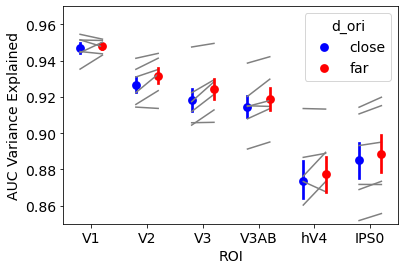

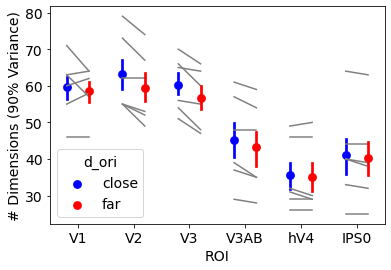

In [756]:
dodge=.4
for ri,roi in enumerate(roi_snag):
    vals= [dim_sum[(dim_sum.d_ori=='close')&(dim_sum.roi==roi)].auc.values,
       dim_sum[(dim_sum.d_ori=='far')&(dim_sum.roi==roi)].auc.values]
    plt.plot([ri-dodge/2,ri+dodge/2],vals,'gray')

plt.ylim(0.85,.97)
sns.pointplot(x='roi',y='auc',data=dim_sum[dim_sum.d_ori!='diff'],hue='d_ori',ci=68,dodge=dodge,palette=['b','r'],
             linestyles='none')
plt.xlabel('ROI')
plt.ylabel('AUC Variance Explained')
# sav_fig('AUC_roi_d_ori')
plt.show()

for ri,roi in enumerate(roi_snag):
    vals= [dim_sum[(dim_sum.d_ori=='close')&(dim_sum.roi==roi)].dim.values,
       dim_sum[(dim_sum.d_ori=='far')&(dim_sum.roi==roi)].dim.values]
    plt.plot([ri-dodge/2,ri+dodge/2],vals,'gray')

sns.pointplot(x='roi',y='dim',data=dim_sum[dim_sum.d_ori!='diff'],hue='d_ori',ci=68,dodge=dodge,palette=['b','r'],
             linestyles='none')
plt.xlabel('ROI')
plt.ylabel('# Dimensions (90% Variance)')
# sav_fig('DIM_roi_d_ori')
plt.show()

In [762]:
foo = np.array([[5,3,5],[4,2,1]])
foo

array([[5, 3, 5],
       [4, 2, 1]])

In [763]:
foo.shape

(2, 3)

In [736]:
roi_show

['V1', 'V2', 'V3', 'IPS0']

ZeroDivisionError: integer division or modulo by zero

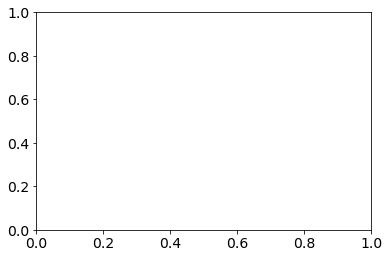

In [733]:
plt.plot([ri,ri+.5],vals)

In [732]:
ri

6

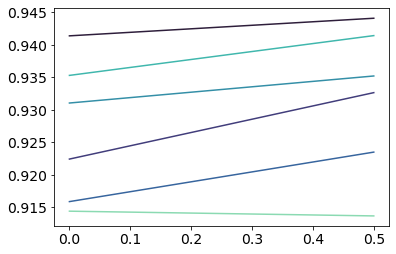

In [730]:
roi='V2'
vals= [dim_sum[(dim_sum.d_ori=='close')&(dim_sum.roi==roi)].auc.values,
       dim_sum[(dim_sum.d_ori=='far')&(dim_sum.roi==roi)].auc.values]
plt.plot([0,.5],vals)

Text(0, 0.5, '$\\Delta$ # Dimensions')

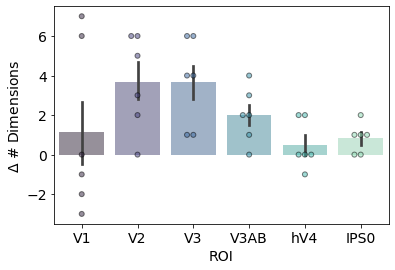

In [667]:
sns.set_palette('mako',6)
sns.barplot(x='roi',y='dim',data=dim_sum[dim_sum.d_ori=='diff'],ci=68,alpha=.5)
sns.swarmplot(x='roi',y='dim',data=dim_sum[dim_sum.d_ori=='diff'],alpha=.5,edgecolor='k',linewidth=1)
plt.xlabel('ROI')
plt.ylabel('$\Delta$ # Dimensions')
# sav_fig('Dim_roi_delta_d_ori')

In [758]:
# stats 
for roi in roi_snag:
    this_dat = dim_sum.loc[(dim_sum.d_ori=='diff')&(dim_sum.roi==roi),'dim'].values
    this_t = scipy.stats.ttest_1samp(this_dat,0)
    print('%s:\t %.2f p=%.3f' %(roi,this_t[0],this_t[1]/2))

V1:	 0.67 p=0.266
V2:	 3.71 p=0.007
V3:	 3.99 p=0.005
V3AB:	 3.46 p=0.009
hV4:	 1.00 p=0.182
IPS0:	 2.71 p=0.021


In [659]:
sns.pointplot(x='roi',y='dim_close',data=dim_sum,ci=68,dodge=1)
sns.pointplot(x='roi',y='dim_far',data=dim_sum,color='r',ci=68)

ValueError: Could not interpret input 'dim_close'

In [508]:
dim_sum

,subj,roi,dim,d_ori
0,UCSD054,V1,46.0,close
1,UCSD054,V1,52.0,far
2,UCSD054,V1,-6.0,diff
3,UCSD054,V2,55.0,close
4,UCSD054,V2,53.0,far
...,...,...,...,...
103,UCSD064,hV4,49.0,far
104,UCSD064,hV4,0.0,diff
105,UCSD064,IPS0,44.0,close
106,UCSD064,IPS0,44.0,far


<AxesSubplot:xlabel='roi', ylabel='d_dim'>

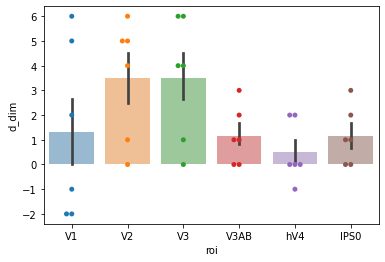

In [424]:
dim_sum['d_dim'] = dim_sum['dim_close']-dim_sum['dim_far']
sns.barplot(x='roi',y='d_dim',data=dim_sum,ci=68,alpha=.5)
sns.swarmplot(x='roi',y='d_dim',data=dim_sum)

Ttest_relResult(statistic=0.06454404734592405, pvalue=0.9510380833046309)

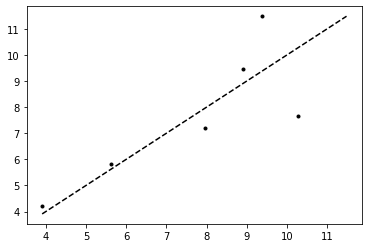

In [408]:
this_var = PR
plt.plot(this_var[:,0],this_var[:,1],'k.')
rng = (np.min(this_var),np.max(this_var))
plt.plot(rng,rng,'k--')
scipy.stats.ttest_rel(this_var[:,0],this_var[:,1])

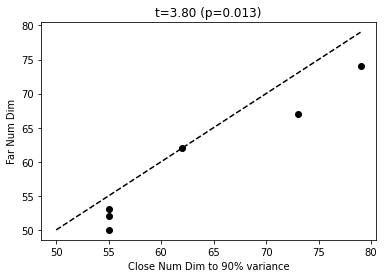

<AxesSubplot:>

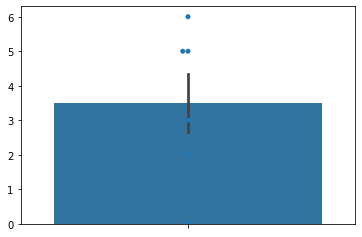

In [402]:
plt.plot(n_dims[:,0],n_dims[:,1],'ko')
rng = (np.min(n_dims),np.max(n_dims))
plt.plot(rng,rng,'k--')
sts = scipy.stats.ttest_rel(n_dims[:,0],n_dims[:,1])
plt.title('t=%.2f (p=%.3f)' %sts)
plt.xlabel('Close Num Dim to %d%% variance' %(var_cuttoff*100))
plt.ylabel('Far Num Dim')
plt.show()

d_num_featurse = n_dims[:,0]-n_dims[:,1]
plt.figure
sns.barplot(y=d_num_featurse,ci=68)
sns.swarmplot(y=d_num_featurse,edgecolor='k')

In [604]:
score.shape

(884, 214)

In [605]:
evectors.shape

(214, 214)

In [ ]:
scipy.

In [609]:
d_use.shape

(884, 214)

In [670]:
evectors.shape

(214, 214)

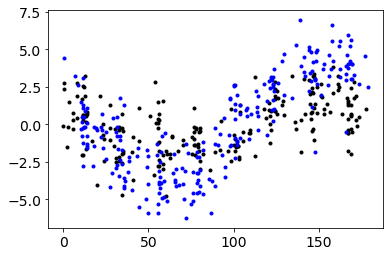

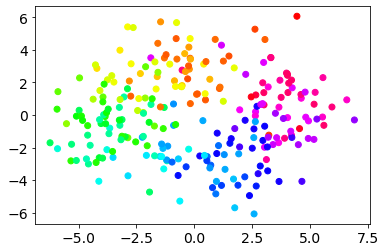

In [694]:
# foo = (d_use-np.mean(d_use,0))@evectors
# plt.plot(ori_task,foo[:,2],'k.')
# plt.plot(ori_task,score[:,2],'r.')
d_view=1
project_far_close = (d_use[close]-np.mean(d_use[close],0))@evectors_far
project_close_far = (d_use[far]-np.mean(d_use[far],0))@evectors_close
plt.plot(ori_task[close],project_far_close[:,d_view],'k.')
plt.plot(ori_task[far],score_far[:,d_view],'b.')
plt.show()
d_view=(1,2)

# plt.scatter(project_far_close[:,d_view[0]],project_far_close[:,d_view[1]],c=ori_task[close],cmap='hsv')
plt.scatter(score_far[:,d_view[0]],score_far[:,d_view[1]],c=ori_task[far],cmap='hsv')
plt.show()

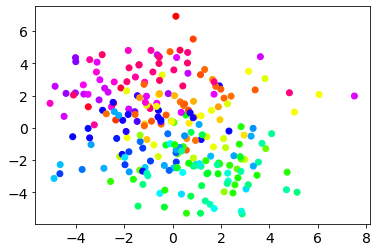

In [699]:
plt.scatter(project_close_far[:,d_view[0]],project_close_far[:,d_view[1]],c=ori_task[far],cmap='hsv')
# plt.scatter(score_close[:,d_view[0]],score_close[:,d_view[1]],c=ori_task[close],cmap='hsv')

220 246


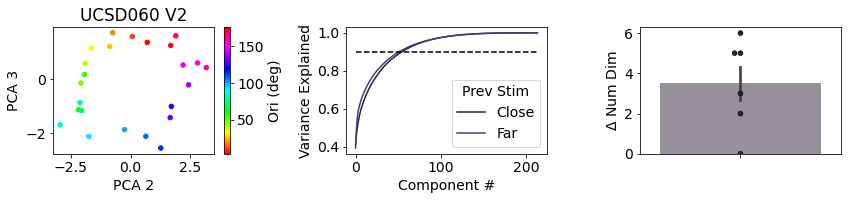

In [669]:
roi_analyze=1
si=1
subj=subjs[si]
d_use = DAT_ALL[si][roi_analyze][0]
ori_task = DAT_ALL[si][roi_analyze][2]

n_block = len(ori_task)//17
trials = np.concatenate([np.arange(17) for _ in range(n_block)])
d_ori = np.concatenate(([0],wrap(ori_task[:-1].values - ori_task[1:].values)))
close = (np.abs(d_ori)<=thresh)&(trials>0)
far = (np.abs(d_ori)>=90-thresh)&(trials>0)
print(np.sum(close),np.sum(far))

score_close, evectors_close, evals_close = pca(d_use[close])  ## this is the answer they need to fill in 
score_far, evectors_far, evals_far = pca(d_use[far])  ## this is the answer they need to fill in 

score, evectors, evals = pca(d_use)  ## this is the answer they need to fill in 


ori_bins = np.linspace(0,180,n_bin+1)
ori_vis = ori_bins[:-1]+(ori_bins[1]-ori_bins[0])/2
binned_scores = np.zeros((n_bin,score.shape[1]))
binned_scores_dist = np.zeros((n_bin,score.shape[1],2))
for i in range(n_bin):
    these_inds = (ori_task>=ori_bins[i])&(ori_task<=ori_bins[i+1])
    binned_scores[i] = np.mean(score[these_inds],0)
    binned_scores_dist[i,:,0] = np.mean(score_close[these_inds[close]],0)
    binned_scores_dist[i,:,1] = np.mean(score_far[these_inds[far]],0)
    
variance_explained_close = get_variance_explained(evals_close[0:])
variance_explained_far = get_variance_explained(evals_far[0:])

# n_dims.append((np.nonzero(variance_explained_close>var_cuttoff)[0][0],np.nonzero(variance_explained_far>var_cuttoff)[0][0]))
plt.figure(figsize=(12,3))
plt.subplot(1,3,1)
inds = (1,2)
plt.scatter(binned_scores[:, inds[0]], binned_scores[:, inds[1]],c=ori_vis,cmap='hsv',s=20)

plt.xlabel('PCA %d' % (inds[0]+1))
plt.ylabel('PCA %d' % (inds[1]+1))

plt.colorbar(label='Ori (deg)')
plt.title('%s %s' %(subj,roi_snag[roi_analyze]))
plt.subplot(1,3,2)

plt.plot(variance_explained_close,label='Close')
plt.plot(variance_explained_far,label='Far')
plt.legend(title='Prev Stim')
plt.xlabel('Component #')
plt.ylabel('Variance Explained')

n_dim = len(variance_explained_close)
plt.plot([0,n_dim],[0.9,0.9],'k--')
plt.subplot(1,3,3)
sns.barplot(y=d_num_featurse,ci=68,alpha=.5)
sns.swarmplot(y=d_num_featurse,edgecolor='k',linewidth=.5)
plt.ylabel('$\Delta$ Num Dim')
plt.tight_layout()

In [601]:
subset_variance_explained_close = get_variance_explained(evals[close])
subset_variance_explained_far = get_variance_explained(evals[far])

IndexError: boolean index did not match indexed array along dimension 0; dimension is 214 but corresponding boolean dimension is 884

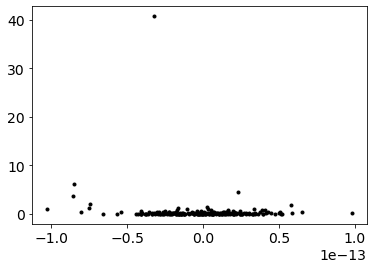

In [608]:
# plt.plot(evals
score.shape
plt.plot(np.sum(score,0),evals,'k.')

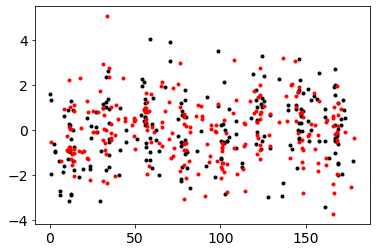

In [600]:
ind=4
plt.plot(ori_task[close],score[close,ind],'k.')
plt.plot(ori_task[far],score[far,ind],'r.')

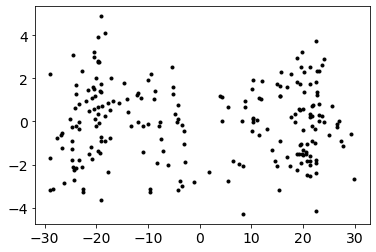

In [586]:
ind = 2
plt.plot(d_ori[close],score[close,ind],'k.')

Text(0.5, 1.0, 'PC 4')

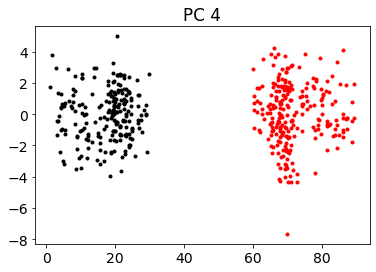

In [580]:
ind = 3
plt.plot(np.abs(d_ori[close]),score_close[:,ind],'k.')
plt.title('PC %d' %(ind+1))
plt.plot(np.abs(d_ori[far]),score_far[:,ind],'r.')
plt.title('PC %d' %(ind+1))
# ind = 3
# plt.plot(d_ori[close],score_close[:,ind],'k.')

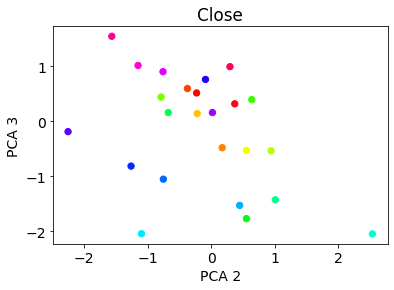

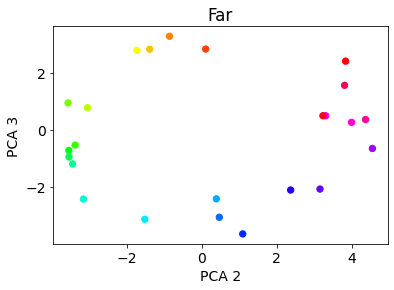

In [568]:
# plt.scatter(binned_scores_dist[:, inds[0],0], binned_scores_dist[:, inds[1],0],c=ori_vis,cmap='hsv',s=40)
inds = (1,2)
plt.scatter(binned_scores_dist[:, inds[0],0], binned_scores_dist[:, inds[1],0],c=ori_vis,cmap='hsv',s=40)
plt.xlabel('PCA %d' % (inds[0]+1))
plt.ylabel('PCA %d' % (inds[1]+1))
plt.title('Close')

plt.show()
plt.scatter(binned_scores_dist[:, inds[0],1], binned_scores_dist[:, inds[1],1],c=ori_vis,cmap='hsv',s=40)
plt.xlabel('PCA %d' % (inds[0]+1))
plt.ylabel('PCA %d' % (inds[1]+1))
plt.title('Far')
plt.show()

In [ ]:
plt.scatter(binned_scores_dist[:, inds[0],0], ,c=ori_vis,cmap='hsv',s=40)

(-3.5, 3.5)

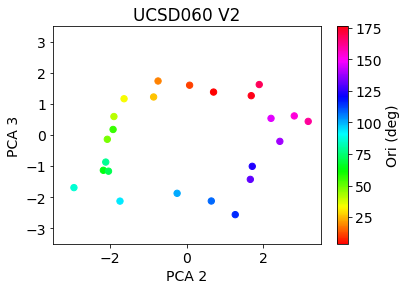

In [637]:
# inds = (0,1)
inds = (1,2)
plt.scatter(binned_scores[:, inds[0]], binned_scores[:, inds[1]],c=ori_vis,cmap='hsv',s=40)

plt.xlabel('PCA %d' % (inds[0]+1))
plt.ylabel('PCA %d' % (inds[1]+1))

plt.colorbar(label='Ori (deg)')
plt.title('%s %s' %(subj,roi_snag[roi_analyze]))
lim = (-3.5,3.5)
plt.xlim(lim)
plt.ylim(lim)

(-3.5, 3.5)

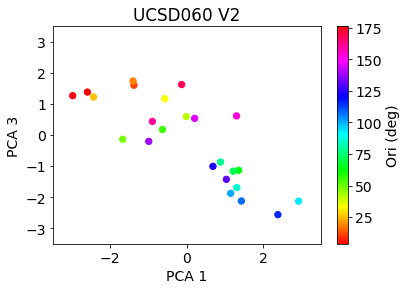

In [521]:
inds = (0,2)
plt.scatter(binned_scores[:, inds[0]], binned_scores[:, inds[1]],c=ori_vis,cmap='hsv',s=40)

plt.xlabel('PCA %d' % (inds[0]+1))
plt.ylabel('PCA %d' % (inds[1]+1))

plt.colorbar(label='Ori (deg)')
plt.title('%s %s' %(subj,roi_snag[roi_analyze]))
lim = (-3.5,3.5)
plt.xlim(lim)
plt.ylim(lim)
# sav_fig('PCA_exDim')

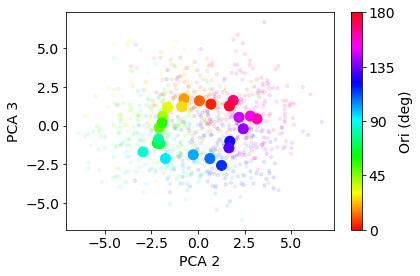

In [718]:
score.shape
inds = (1,2)
# plt.plot(score[:,inds[0]],score[:,inds[1]],'k.') 
plt.scatter(score[:,inds[0]],score[:,inds[1]],c=ori_task,cmap='hsv',s=10,alpha=.1)
plt.scatter(binned_scores[:, inds[0]], binned_scores[:, inds[1]],c=ori_vis,cmap='hsv',s=100,marker='o')
plt.xlabel('PCA %d' % (inds[0]+1))
plt.ylabel('PCA %d' % (inds[1]+1))

plt.colorbar(label='Ori (deg)',ticks=[0,45,90,135,180])
plt.clim(0,180)
# sav_fig('ExamplePCA_all_dots')
plt.show()

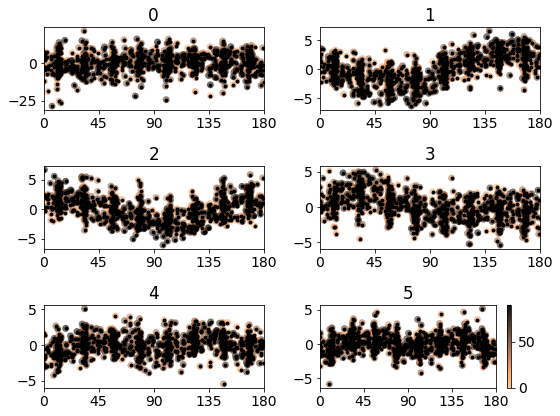

In [634]:

plt.figure(figsize=(8,6))
for i in range(6):
    plt.subplot(3,2,i+1)
    
    plt.plot(ori_task,score[:,i],'k.')
    plt.set_cmap('copper_r')
    plt.scatter(ori_task,score[:,i],c=np.abs(d_ori),alpha=.5)
#     plt.plot(d_ori,score[:,i],'k.')
    plt.xlim([0,180])
    plt.xticks([0,45,90,135,180])
    plt.title(i)
plt.colorbar()
plt.tight_layout()
plt.show()
# plt.plot(np.abs(d_ori),score[:,ind],'k.')

(-3.5, 3.5)

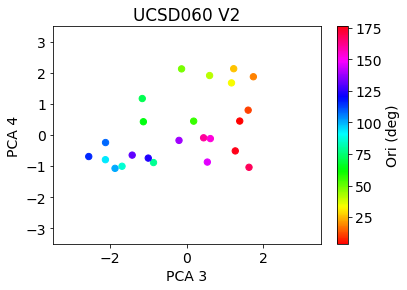

In [549]:
inds = (2,3)
plt.scatter(binned_scores[:, inds[0]], binned_scores[:, inds[1]],c=ori_vis,cmap='hsv',s=40)

plt.xlabel('PCA %d' % (inds[0]+1))
plt.ylabel('PCA %d' % (inds[1]+1))

plt.colorbar(label='Ori (deg)')
plt.title('%s %s' %(subj,roi_snag[roi_analyze]))
lim = (-3.5,3.5)
plt.xlim(lim)
plt.ylim(lim)
# sav_fig('PCA_exDim')

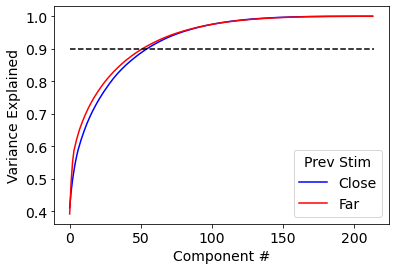

In [488]:
plt.plot(variance_explained_close,'b',label='Close',)
plt.plot(variance_explained_far,'r',label='Far')
plt.legend(title='Prev Stim')
plt.xlabel('Component #')
plt.ylabel('Variance Explained')

n_dim = len(variance_explained_close)
plt.plot([0,n_dim],[0.9,0.9],'k--')
# sav_fig('Dim_example_close_far')

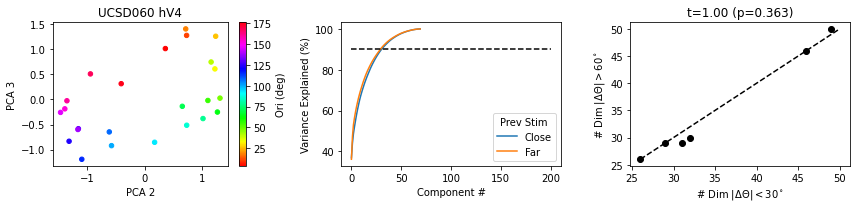

In [382]:
plt.figure(figsize=(12,3))
plt.subplot(1,3,1)
inds = (1,2)
plt.scatter(binned_scores[:, inds[0]], binned_scores[:, inds[1]],c=ori_vis,cmap='hsv',s=20)

plt.xlabel('PCA %d' % (inds[0]+1))
plt.ylabel('PCA %d' % (inds[1]+1))
# plt.axis('equal')
# plot_pca_labels(binned_scores,ori_vis,(1,2))
plt.colorbar(label='Ori (deg)')
plt.title('%s %s' %(subj,roi_snag[roi_analyze]))
plt.subplot(1,3,2)

plt.plot(variance_explained_close*100,label='Close')
plt.plot(variance_explained_far*100,label='Far')
plt.legend(title='Prev Stim')
plt.xlabel('Component #')
plt.ylabel('Variance Explained (%)')

plt.plot([0,200],np.ones(2)*100*var_cuttoff,'k--')
plt.subplot(1,3,3)
plt.plot(n_dims[:,0],n_dims[:,1],'ko')
rng = (np.min(n_dims),np.max(n_dims))
plt.plot(rng,rng,'k--')
sts = scipy.stats.ttest_rel(n_dims[:,0],n_dims[:,1])
plt.title('t=%.2f (p=%.3f)' %sts)
plt.xlabel("# Dim $ |\Delta\Theta| <30^\circ$")
plt.ylabel("# Dim $ |\Delta\Theta| >60^\circ$")
plt.tight_layout()

In [358]:
np.nonzero(variance_explained_close>.9)[0][0]
np.nonzero(variance_explained_far>.9)[0][0]

50

220 246


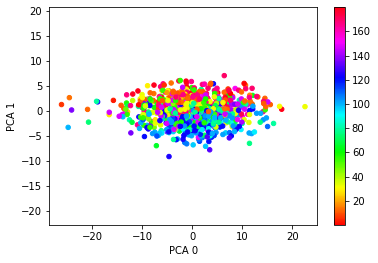

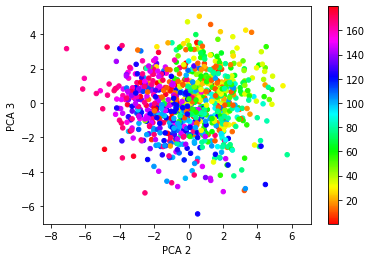

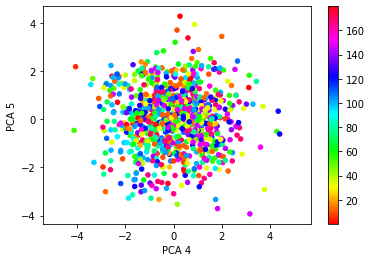

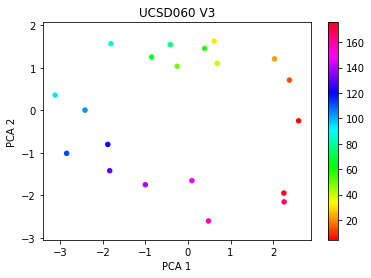

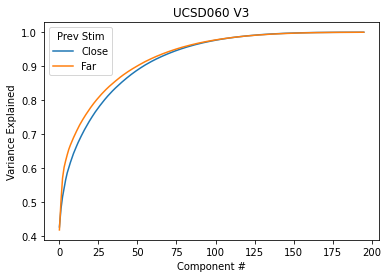

In [233]:
thresh =30
d_use = [dat_task_train,dat_task_full][0]
n_block = len(ori_task)//17
trials = np.concatenate([np.arange(17) for _ in range(n_block)])
d_ori = np.concatenate(([0],wrap(ori_task[:-1].values - ori_task[1:].values)))
close = (np.abs(d_ori)<=thresh)&(trials>0)
far = (np.abs(d_ori)>=90-thresh)&(trials>0)
print(np.sum(close),np.sum(far))

score_close, evectors_close, evals_close = pca(d_use[close])  ## this is the answer they need to fill in 
score_far, evectors_far, evals_far = pca(d_use[far])  ## this is the answer they need to fill in 

score, evectors, evals = pca(d_use)  ## this is the answer they need to fill in 

plot_pca_labels(score[:,:],ori_task,(0,1))
plot_pca_labels(score[:,:],ori_task,(2,3))
plot_pca_labels(score[:,:],ori_task,(4,5))

# bin orientation?
n_bin = 20
ori_bins = np.linspace(0,180,n_bin+1)
ori_vis = ori_bins[:-1]+(ori_bins[1]-ori_bins[0])/2
binned_scores = np.zeros((n_bin,score.shape[1]))
for i in range(n_bin):
    these_inds = (ori_task>=ori_bins[i])&(ori_task<=ori_bins[i+1])
    binned_scores[i] = np.mean(score[these_inds],0)
    
plt.title('%s %s' %(subj,roi))
plot_pca_labels(binned_scores,ori_vis,(1,2))


variance_explained_close = get_variance_explained(evals_close[0:])
variance_explained_far = get_variance_explained(evals_far[0:])


plt.plot(variance_explained_close,label='Close')
plt.plot(variance_explained_far,label='Far')
plt.legend(title='Prev Stim')
plt.xlabel('Component #')
plt.ylabel('Variance Explained')
plt.title('%s %s' %(subj,roi))
plt.show()




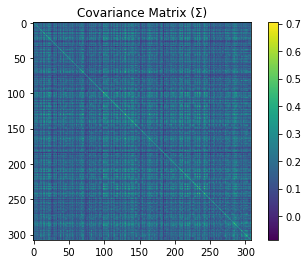

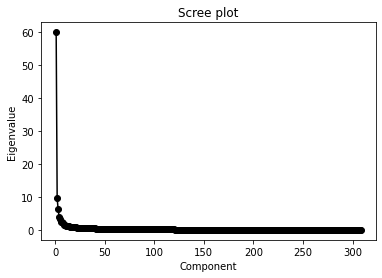

In [213]:
cov_mat.shape
cov_mat = get_sample_cov_matrix(dat_task_train)
plot_covariance(cov_mat)
score, evectors, evals = pca(dat_task_train)  ## this is the answer they need to fill in 
# score, evectors, evals = pca(dat_task_full)  ## this is the answer they need to fill in 
# Uncomment to plot the eigenvalues
plot_eigenvalues(evals, limit=False)

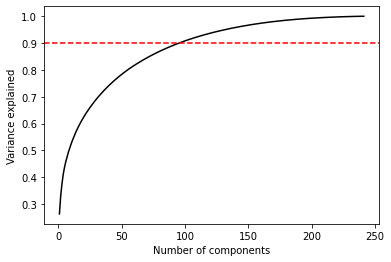

In [194]:
def get_variance_explained(evals):
  """
  Calculates variance explained from the eigenvalues.

  Args:
    evals (numpy array of floats) : Vector of eigenvalues

  Returns:
    (numpy array of floats)       : Vector of variance explained

  """

  #################################################
  ## TO DO for students: calculate the explained variance using the equation
  ## from Section 2.
  # Comment once you've filled in the function
  # raise NotImplementedError("Student excercise: calculate explaine variance!")
  #################################################

  # cumulatively sum the eigenvalues
  csum = np.cumsum(evals)  ## this is the answer they need to fill in 
  # normalize by the sum of eigenvalues
  variance_explained = csum / np.sum(evals)  ## this is the answer they need to fill in 

  return variance_explained


#################################################
## TO DO for students: call the function and plot the variance explained
#################################################

# calculate the variance explained
variance_explained = get_variance_explained(evals)

# Uncomment to plot the variance explained and 90% of the variance explained
plot_variance_explained(variance_explained)


In [241]:
def plot_pca_labels(score,labels,inds=(0,1)):
#     plt.figure()
    plt.scatter(score[:, inds[0]], score[:, inds[1]],c=labels,cmap='hsv',s=20)
    plt.xlabel('PCA %d' % inds[0])
    plt.ylabel('PCA %d' % inds[1])
    plt.axis('equal')
    plt.colorbar()
#     plt.show()

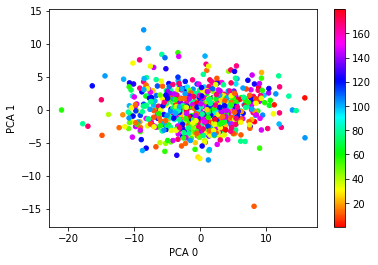

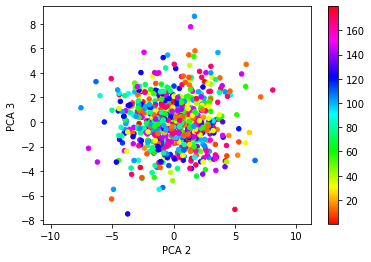

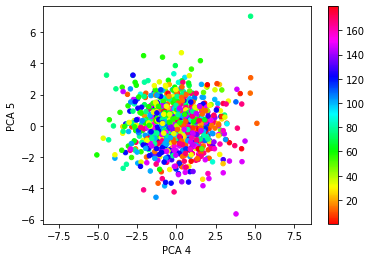

In [196]:
plot_pca_labels(score[:,:],ori_task,(0,1))
plot_pca_labels(score[:,:],ori_task,(2,3))
plot_pca_labels(score[:,:],ori_task,(4,5))

In [197]:
plot_pca_labels(score_close[:,:],ori_task[close],(0,1))
plot_pca_labels(score_close[:,:],ori_task[close],(2,3))
plot_pca_labels(score_close[:,:],ori_task[close],(4,5))

IndexError: Boolean index has wrong length: 884 instead of 816

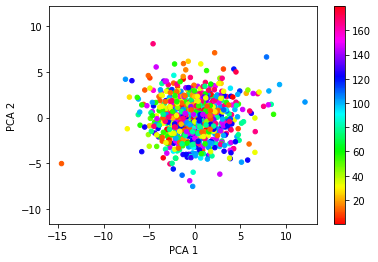

In [198]:
plot_pca_labels(score[:,:],ori_task,(1,2))

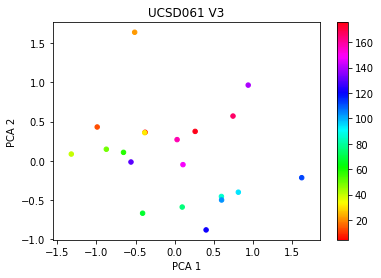

In [200]:
# bin orientation?
n_bin = 20
ori_bins = np.linspace(0,180,n_bin+1)
ori_vis = ori_bins[:-1]+(ori_bins[1]-ori_bins[0])/2
binned_scores = np.zeros((n_bin,score.shape[1]))
for i in range(n_bin):
    these_inds = (ori_task>=ori_bins[i])&(ori_task<=ori_bins[i+1])
    binned_scores[i] = np.mean(score[these_inds],0)
    
plt.title('%s %s' %(subj,roi))
plot_pca_labels(binned_scores,ori_vis,(1,2))


In [201]:
# split values based on d_ori
# dat_task_train


62 57


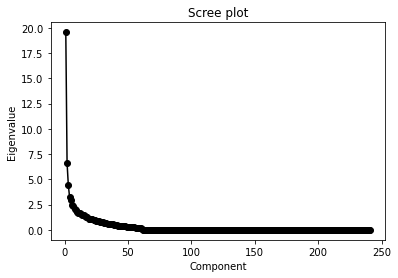

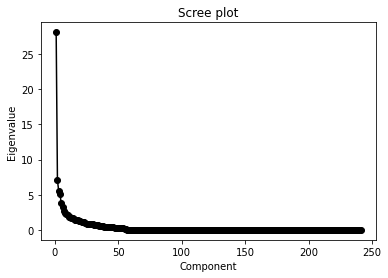

In [202]:
score_close, evectors_close, evals_close = pca(dat_task_train[close])  ## this is the answer they need to fill in 
plot_eigenvalues(evals_close, limit=False)
score_far, evectors_far, evals_far = pca(dat_task_train[far])  ## this is the answer they need to fill in 
plot_eigenvalues(evals_far, limit=False)

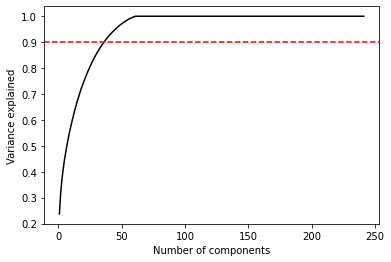

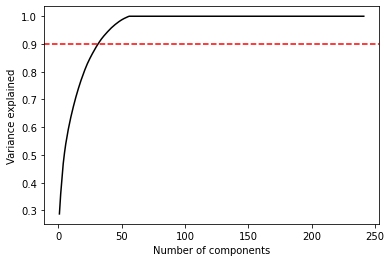

In [203]:
variance_explained_close = get_variance_explained(evals_close[0:])
variance_explained_far = get_variance_explained(evals_far[0:])

# Uncomment to plot the variance explained and 90% of the variance explained
plot_variance_explained(variance_explained_close)
plot_variance_explained(variance_explained_far)

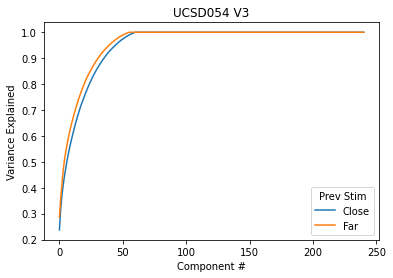

In [217]:
plt.plot(variance_explained_close,label='Close')
plt.plot(variance_explained_far,label='Far')
plt.legend(title='Prev Stim')
plt.xlabel('Component #')
plt.ylabel('Variance Explained')
plt.title('%s %s' %(subj,roi))
plt.show()

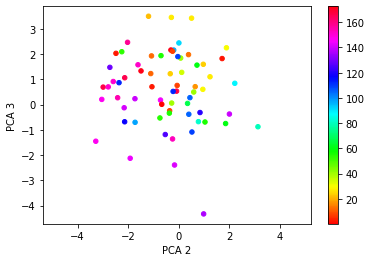

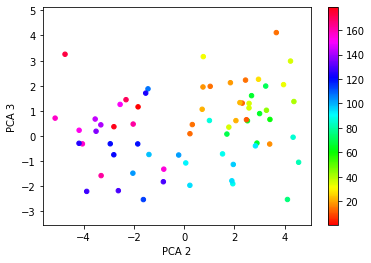

In [172]:
plot_pca_labels(score[close,:],ori_task[close],(2,3))
plot_pca_labels(score[far,:],ori_task[far],(2,3))